In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from CS2_bo_plotters import plot_obj_abs_min
from CS2_bo_plotters import value_plotter
from CS2_bo_plotters import plot_obj
from CS2_bo_plotters import plot_Theta
from CS2_bo_plotters import plot_Theta_min
from CS2_bo_plotters import path_name
from CS2_bo_functions import set_ep
from CS2_bo_functions import plot_org_train

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def csv_to_array(csv_path):
    """
    Turn a csv file into a numpy array so that it can be used with bo_plotters
    
    Parameters:
    -----------
        csv_path: str, path of csv you want to turn into an array
    Returns:
    --------
        csv_array: np.ndarray, array on values in the CSV file
    """
    
    csv_pd = pd.read_csv(csv_path, index_col = False)
    csv_pd.drop(columns=csv_pd.columns[0], 
        axis=1, 
        inplace=True)
    csv_array = csv_pd.to_numpy()
    
    return csv_array

In [3]:
emulator = True
obj = "obj"
sparse_grid = True
sep_fact = 0.7
run = 12
Bo_iter = 6

set_lengthscale = None

if emulator == False:
    t = 20
else:
    t = 100

#Define GP Testing space
p=20
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays  
    
ep = set_ep(emulator, obj, sparse_grid)

tot_iter = bo_iters= 100 #Total Number of iters - Dispayed in job file
tot_runs = 15 #Total Number of runs - Dispayed in job file
DateTime = "2022/10/17/16-10" #Date and Time - Dispayed in job file
is_figure = False
save_figure = False
Theta_True = np.array([1,-1])

run -= 1 #Should be Number you want -1
Bo_iter -= 1 #Iter you want -1

2022/10/17/16-10/CSV_Data/Convergence_Figs/GP_Emulator/Sparse/TP_100/obj/ep_1.0/len_scl_varies/Sep_Fact_0.7/Total_Runs_15/SSE_Conv.csv


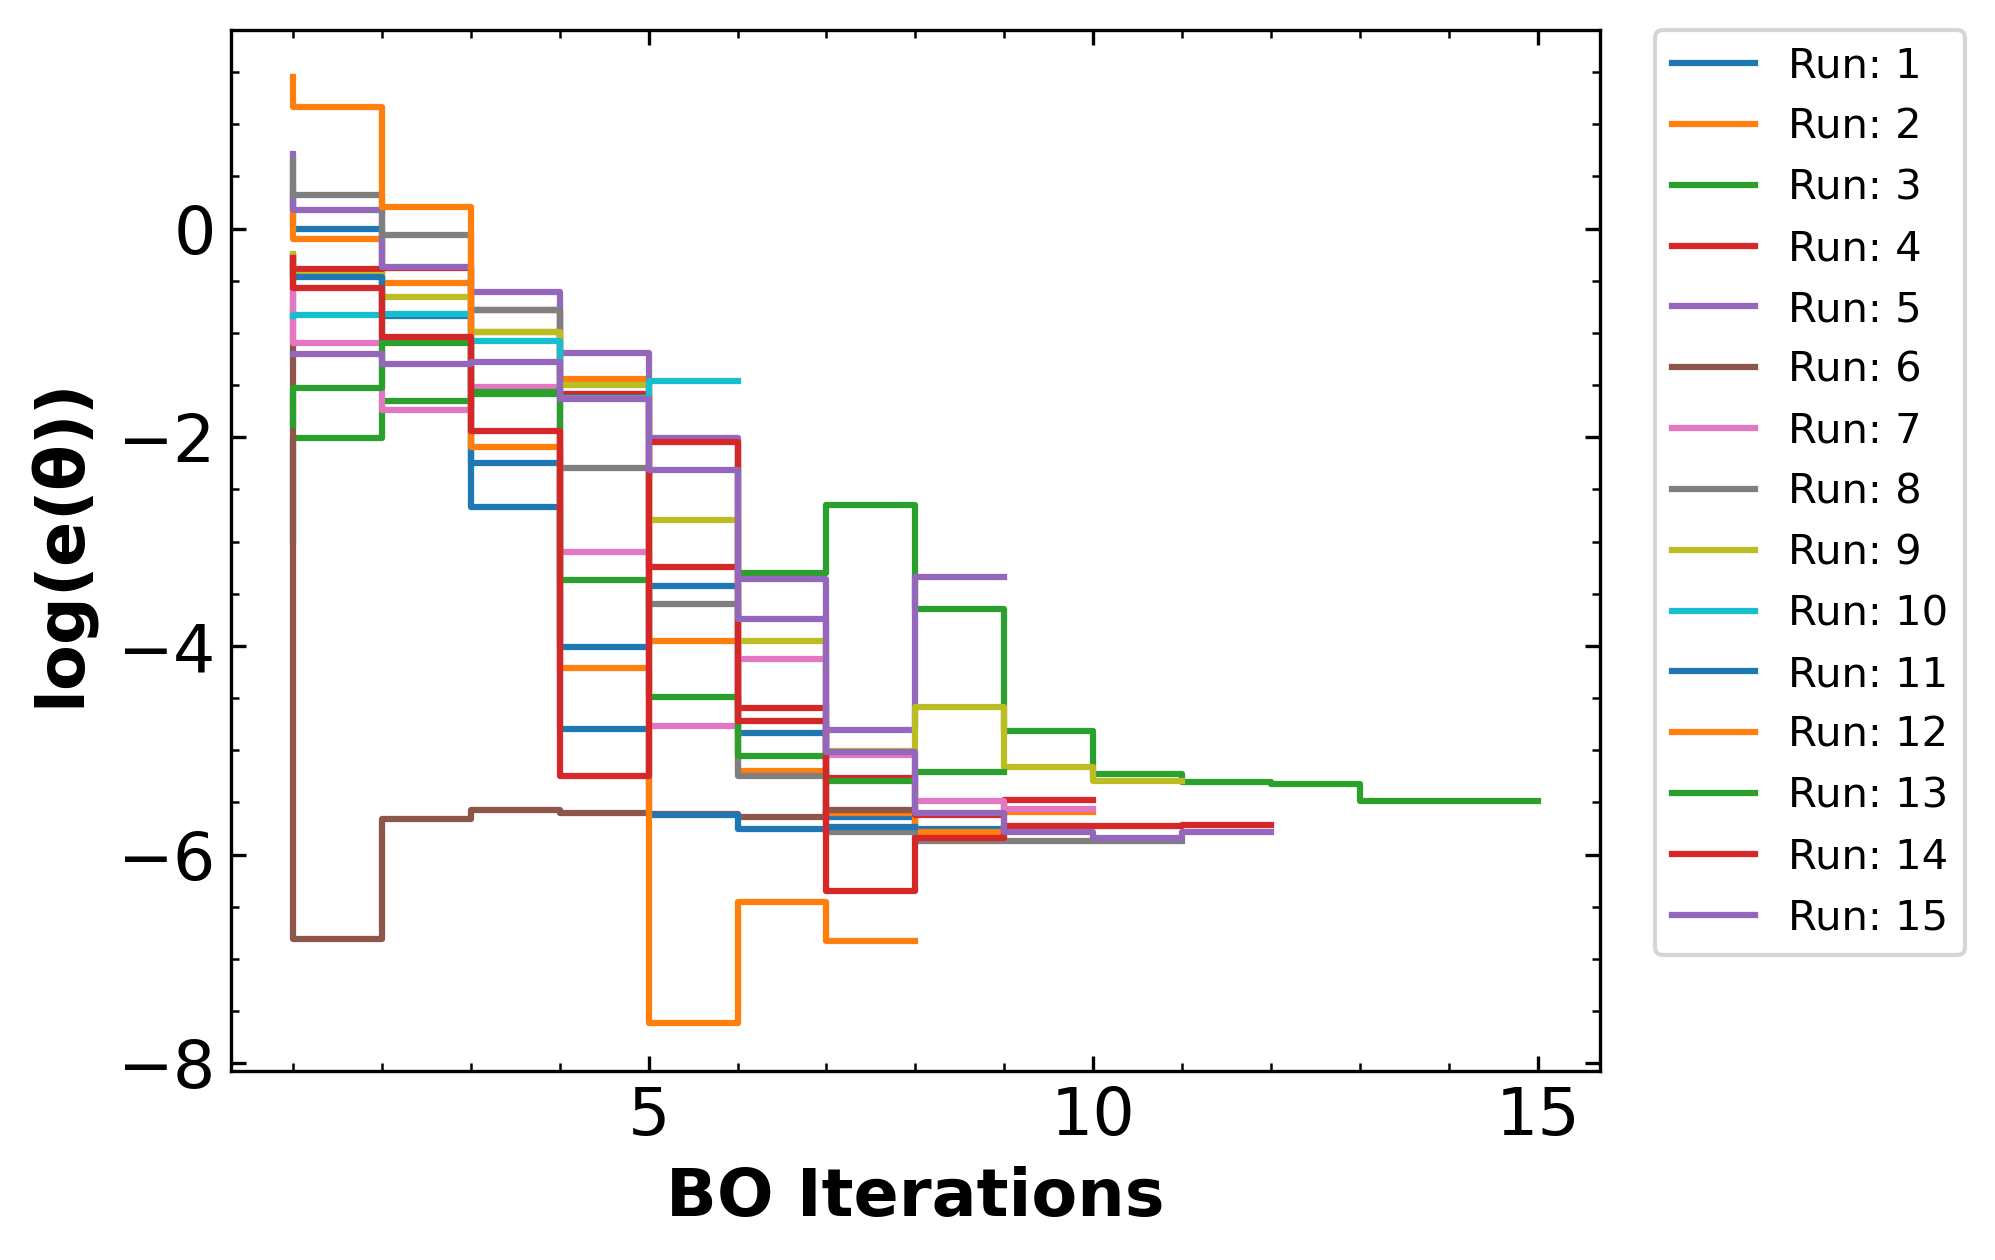

In [4]:
#WORKS
csv_end = ".csv" #For obj
fxn = "plot_obj"

path = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, bo_iter= None, 
          title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                 sep_fact = sep_fact, is_figure = is_figure, csv_end = ".csv")
print(path)
obj_array = csv_to_array(path)
plot_obj(obj_array, t, obj, ep, emulator, sparse_grid, set_lengthscale, save_figure, tot_iter=tot_iter, 
         tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact)

2022/10/17/16-10/CSV_Data/Convergence_Figs/GP_Emulator/Sparse/TP_100/obj/ep_1.0/len_scl_varies/Sep_Fact_0.7/Total_Runs_15/Min_SSE_Conv.csv


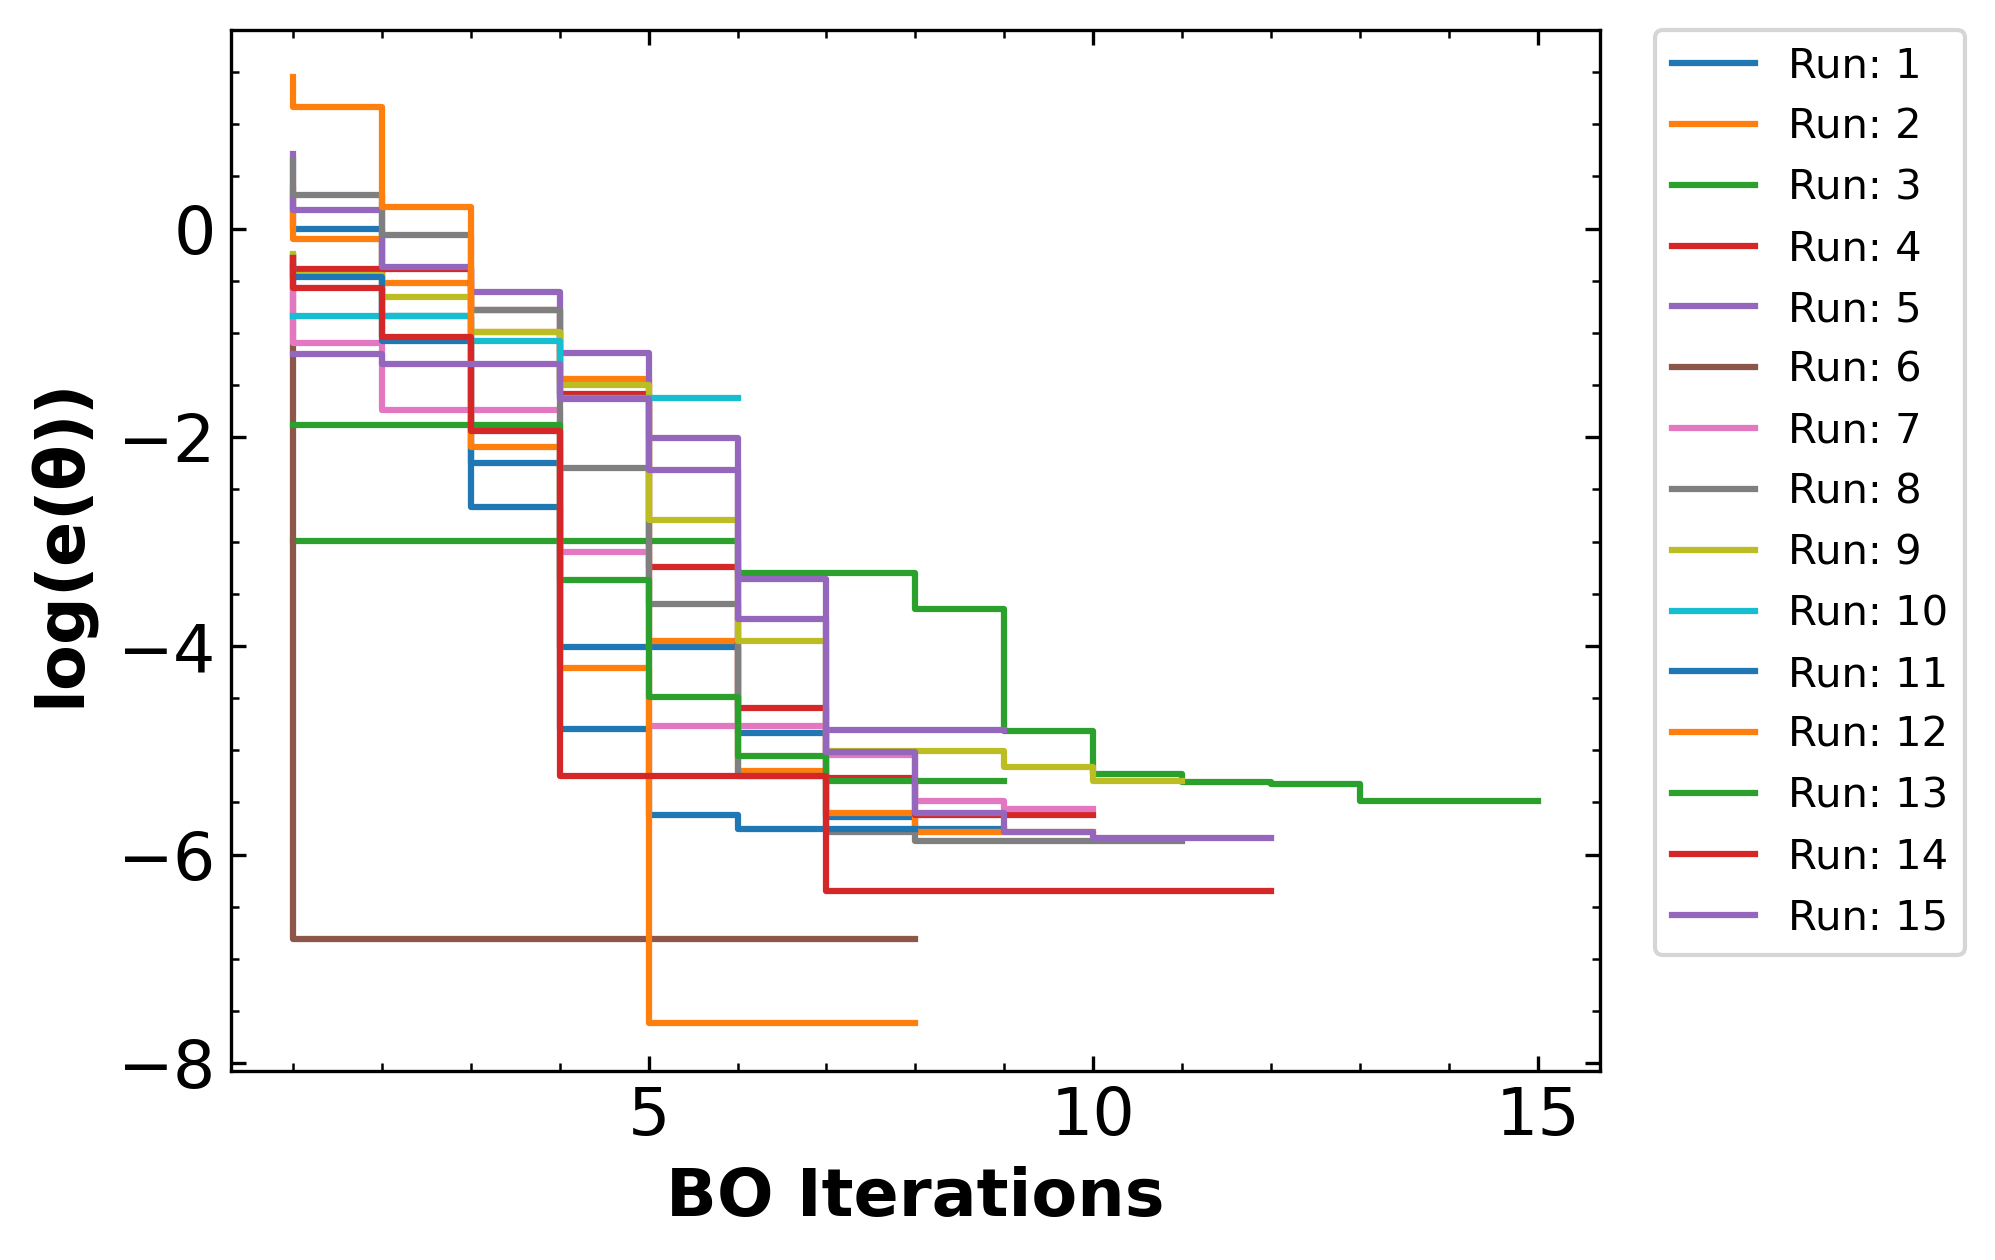

In [5]:
#WORKS
csv_end = ".csv" #For obj
fxn = "plot_obj_abs_min"

path = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, bo_iter= None, 
          title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                 sep_fact = sep_fact, is_figure = is_figure, csv_end = ".csv")
print(path)
obj_abs_min = csv_to_array(path)
plot_obj_abs_min(obj_abs_min, emulator, ep, sparse_grid, set_lengthscale, t, obj, 
                 save_figure, tot_iter, tot_runs,DateTime, sep_fact)

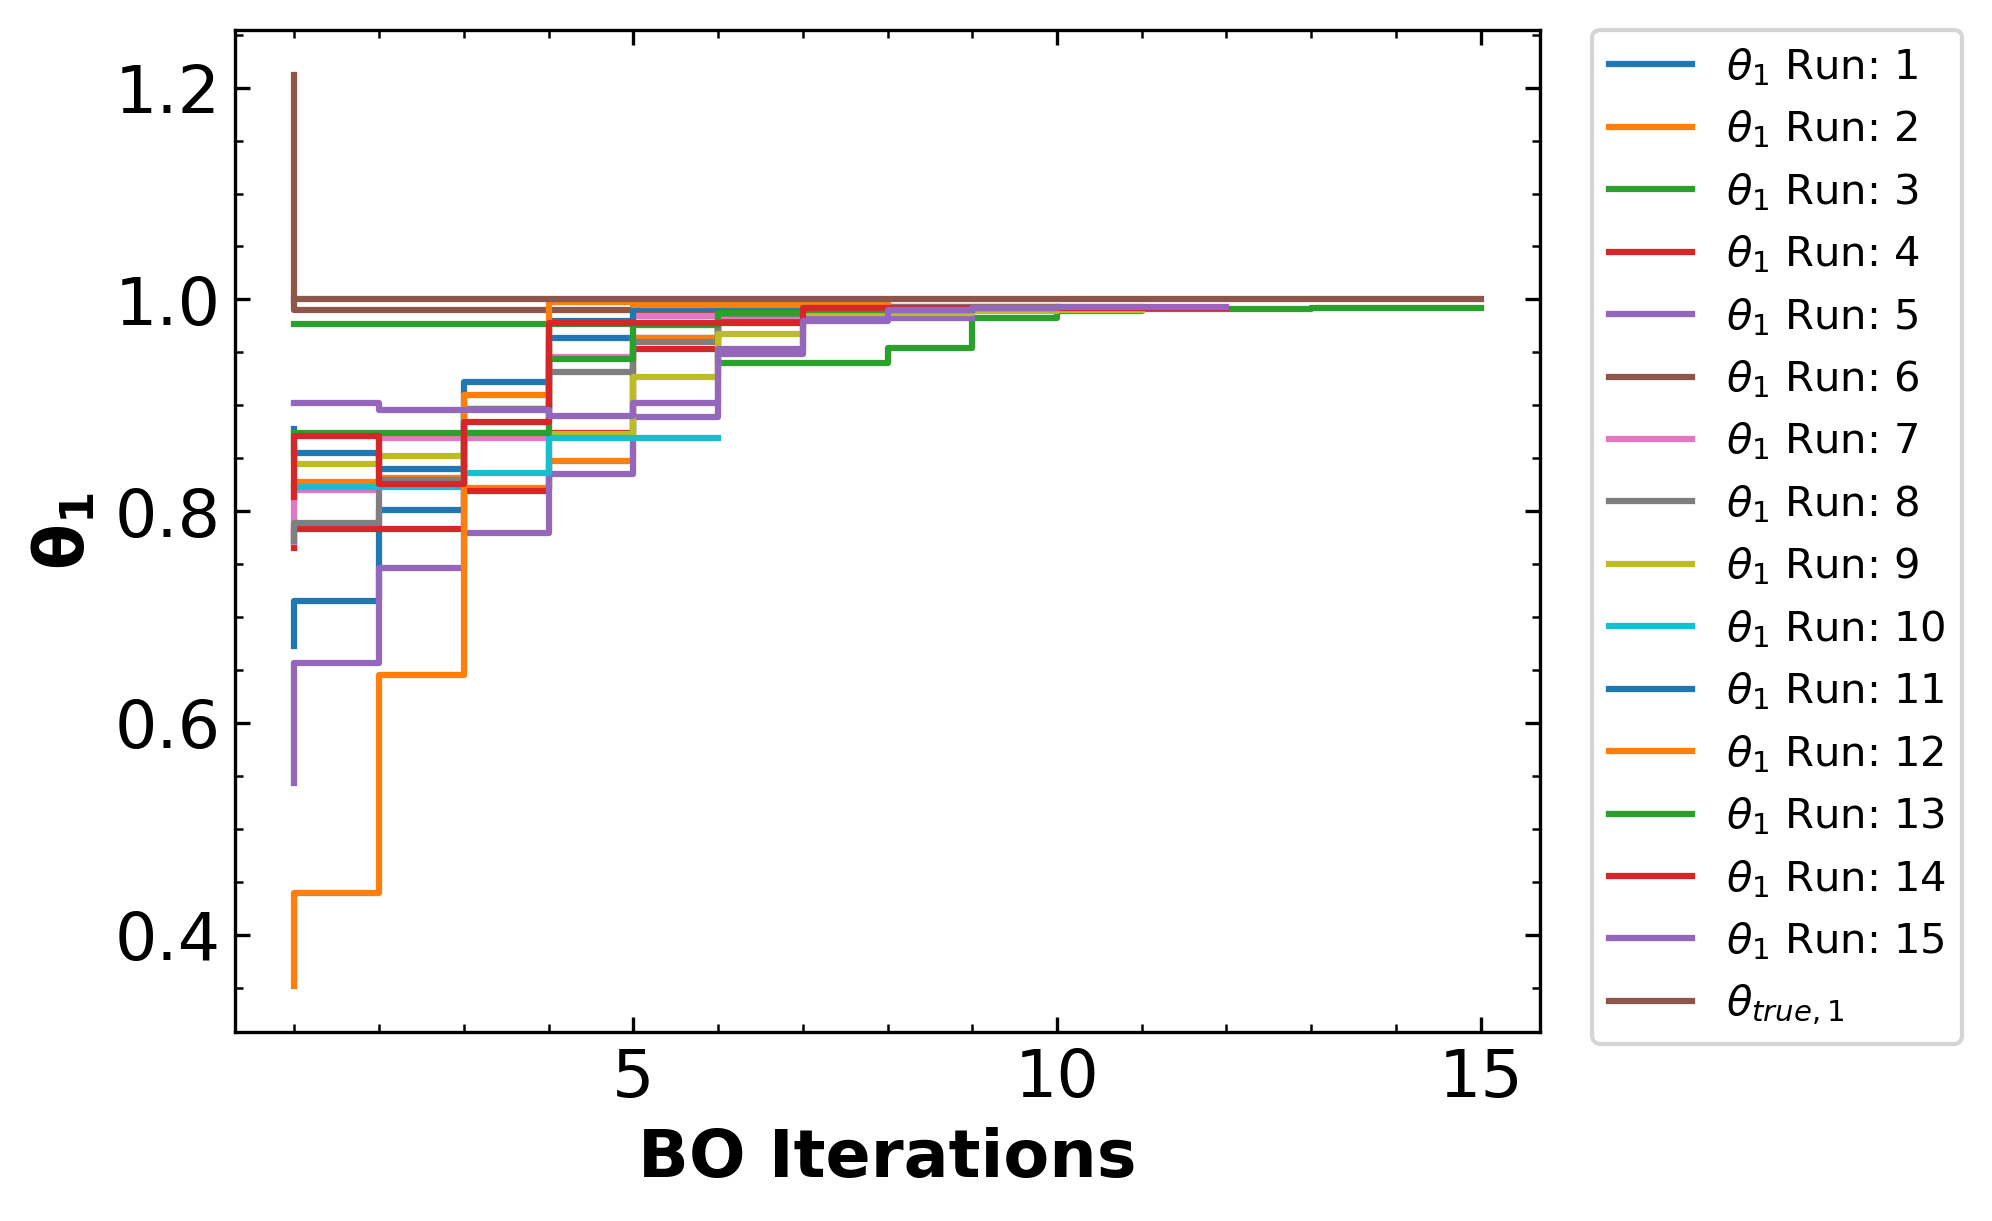

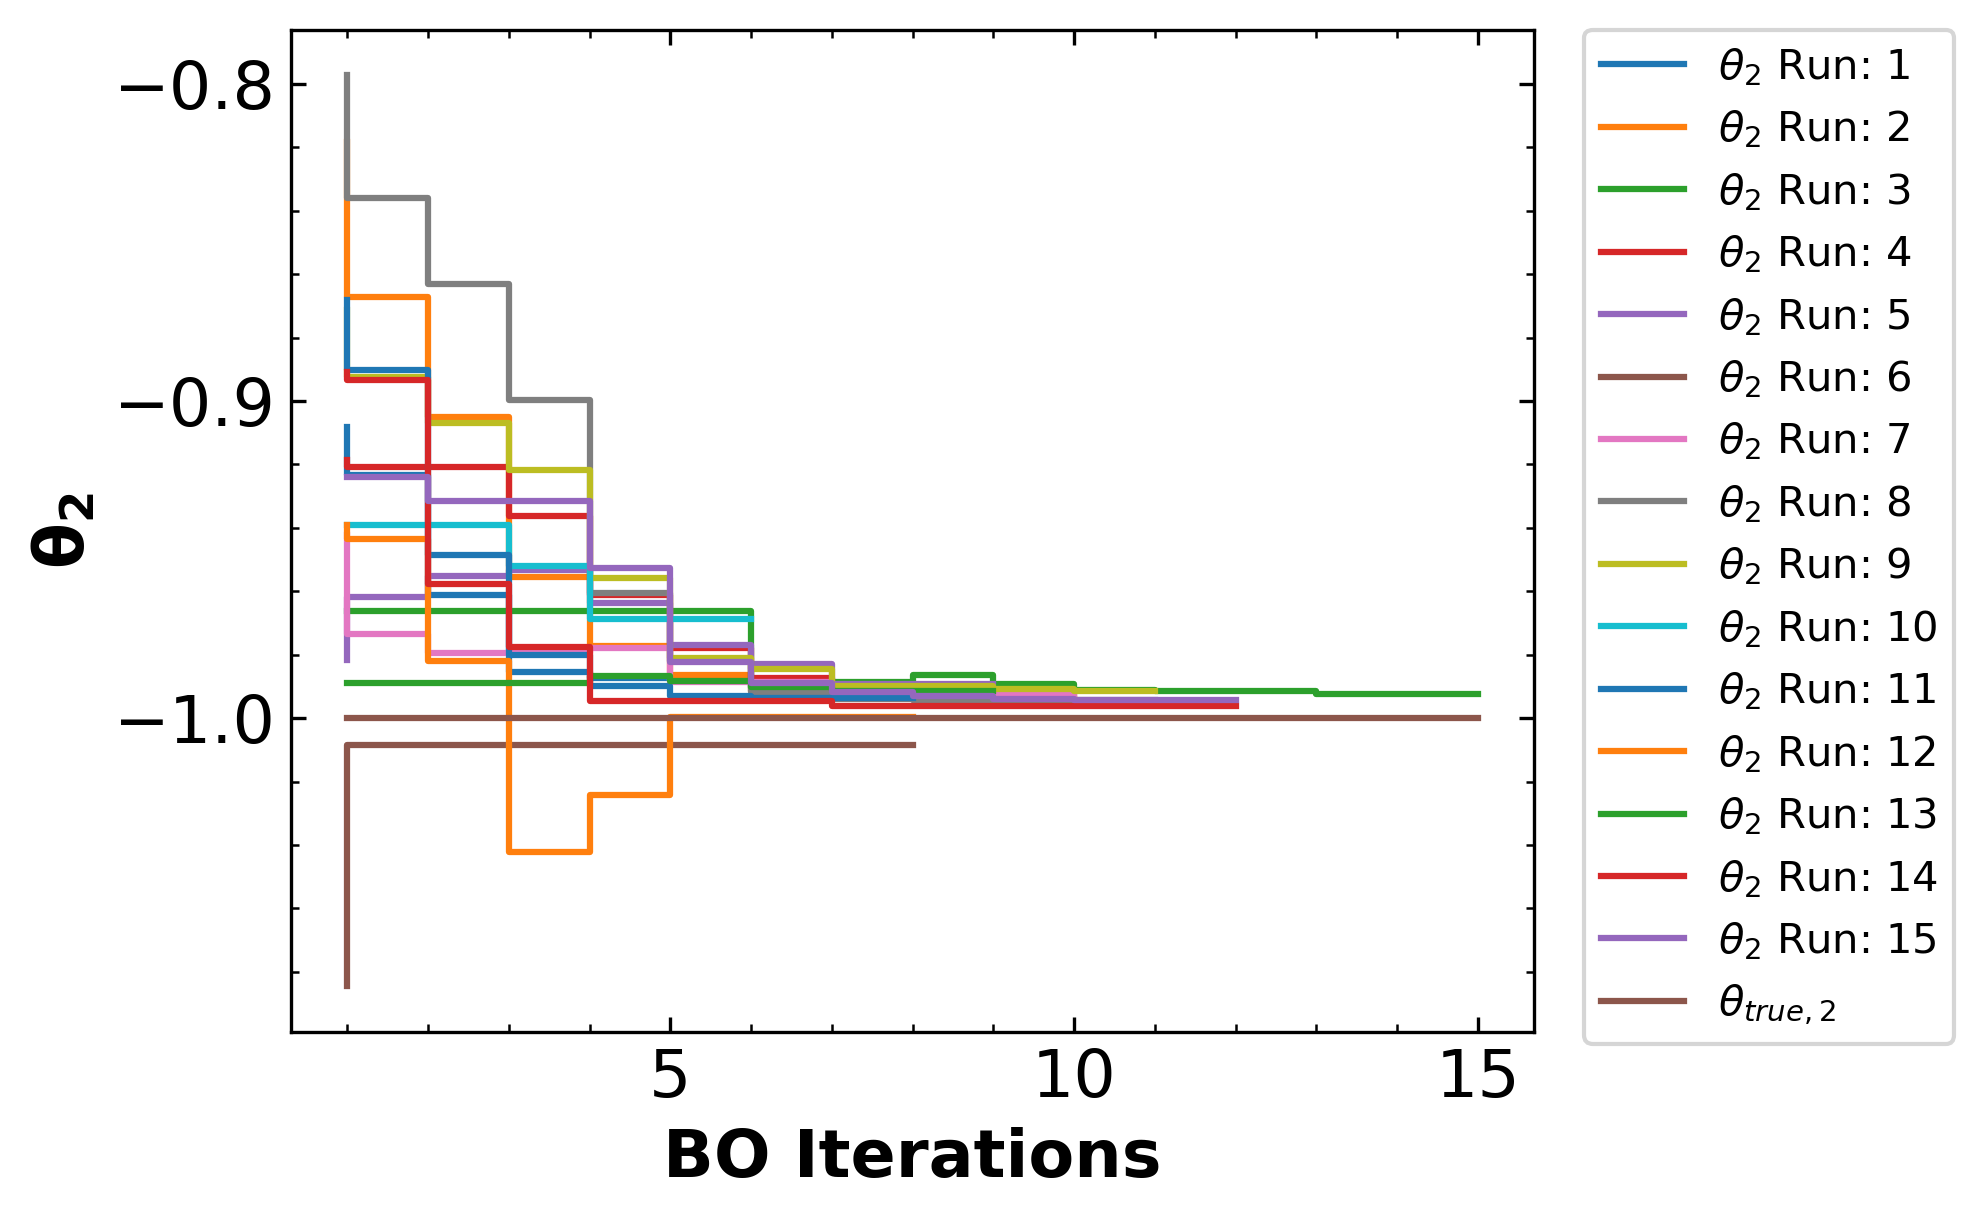

In [6]:
#WORKS
# save_figure = True
fxn = "plot_Theta"
csv_end_1 = "/Theta_Conv_1.csv" #For Thetas #Need to ensure this saves correctly
csv_end_2 = "/Theta_Conv_2.csv" #For Thetas

path_1 = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, bo_iter= None, 
          title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                 sep_fact = sep_fact, is_figure = is_figure, csv_end = csv_end_1)
path_2 = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, bo_iter= None, 
          title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                 sep_fact = sep_fact, is_figure = is_figure, csv_end = csv_end_2)

Theta_array_1 = csv_to_array(path_1)
Theta_array_2 = csv_to_array(path_2)
Theta_array = np.array([Theta_array_1,Theta_array_2]).T
plot_Theta(Theta_array, Theta_True, t, bo_iters, obj, ep, emulator, sparse_grid, set_lengthscale, save_figure, 
           tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact)

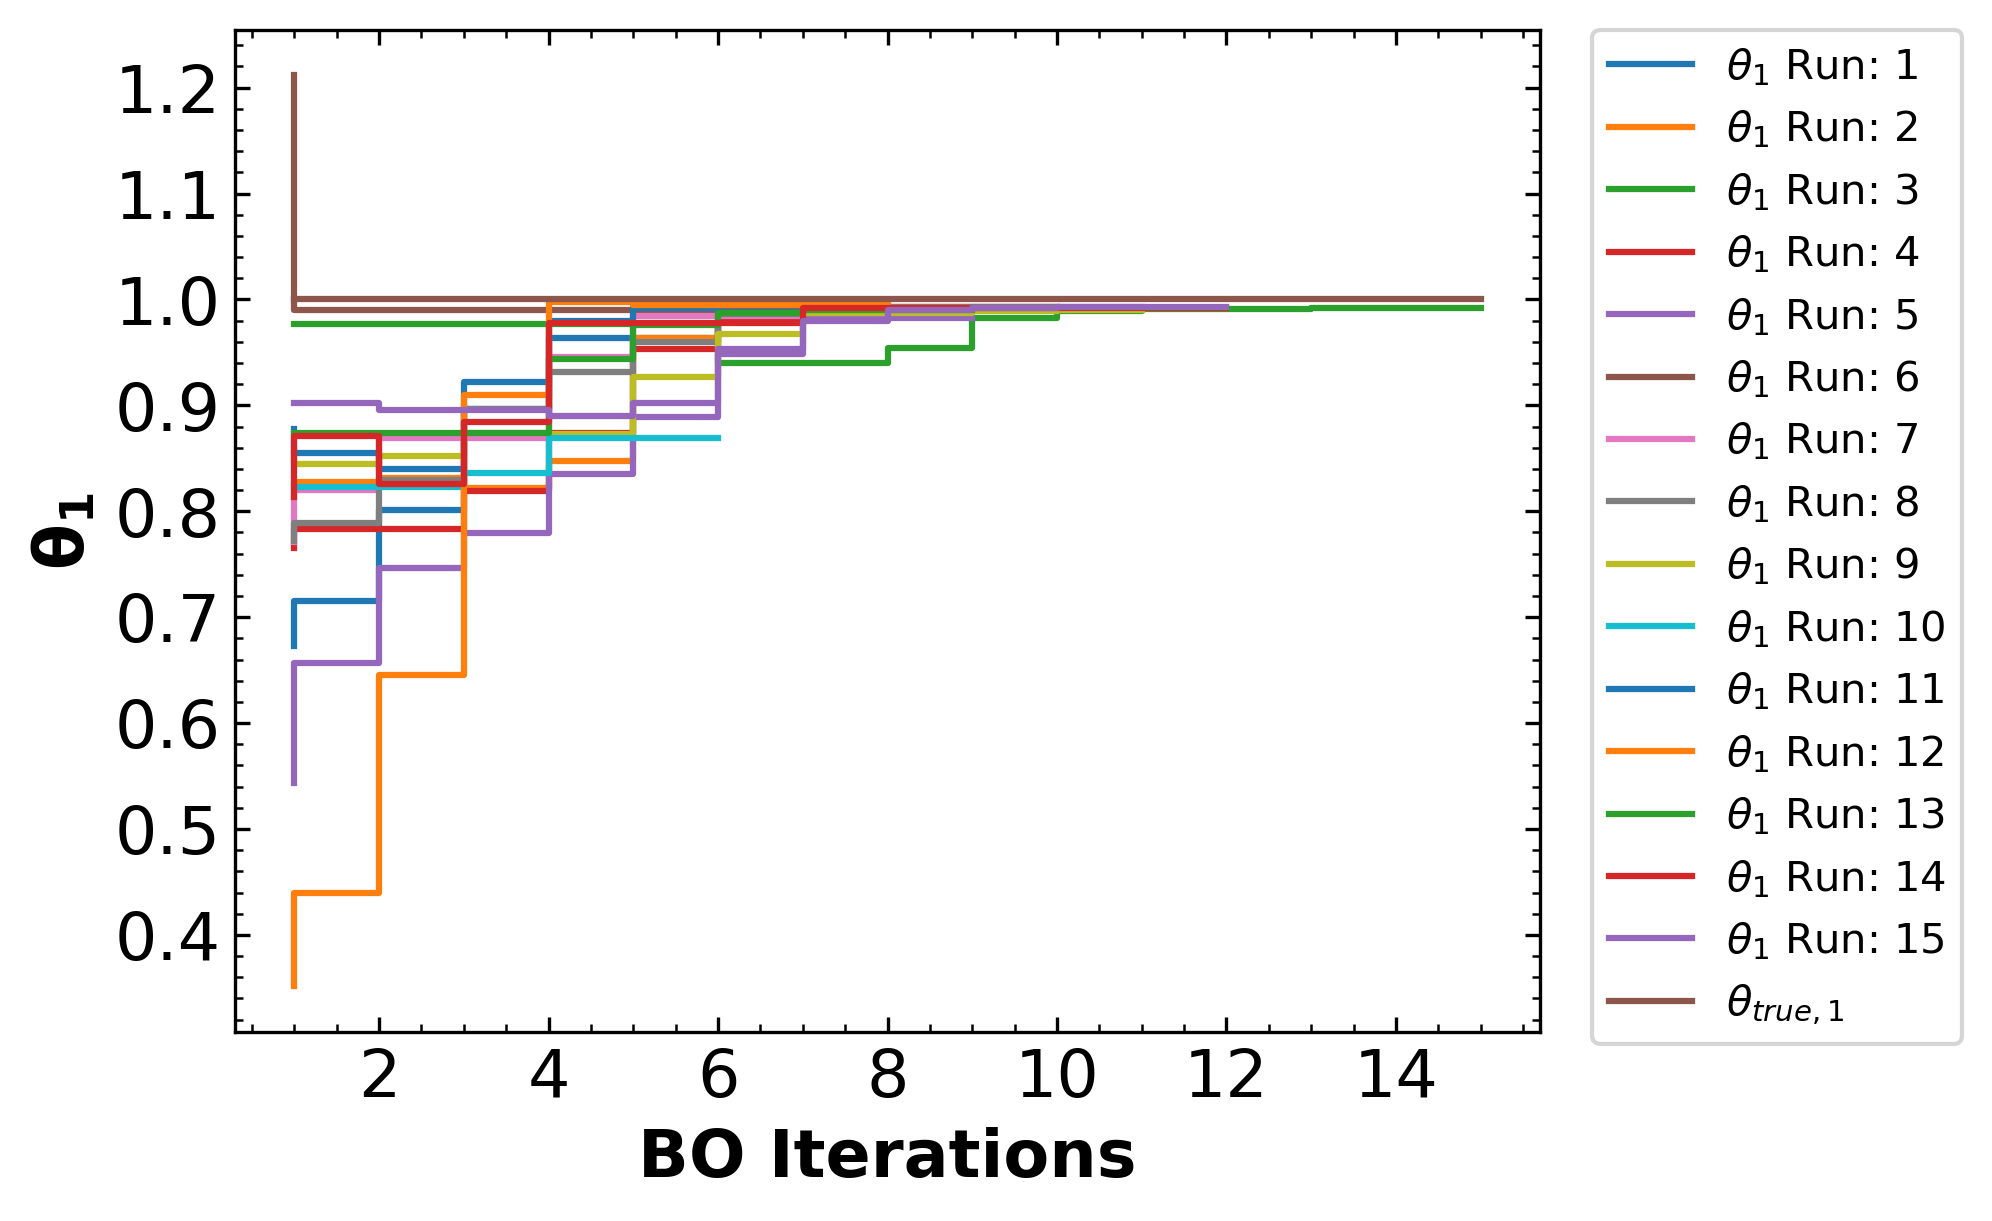

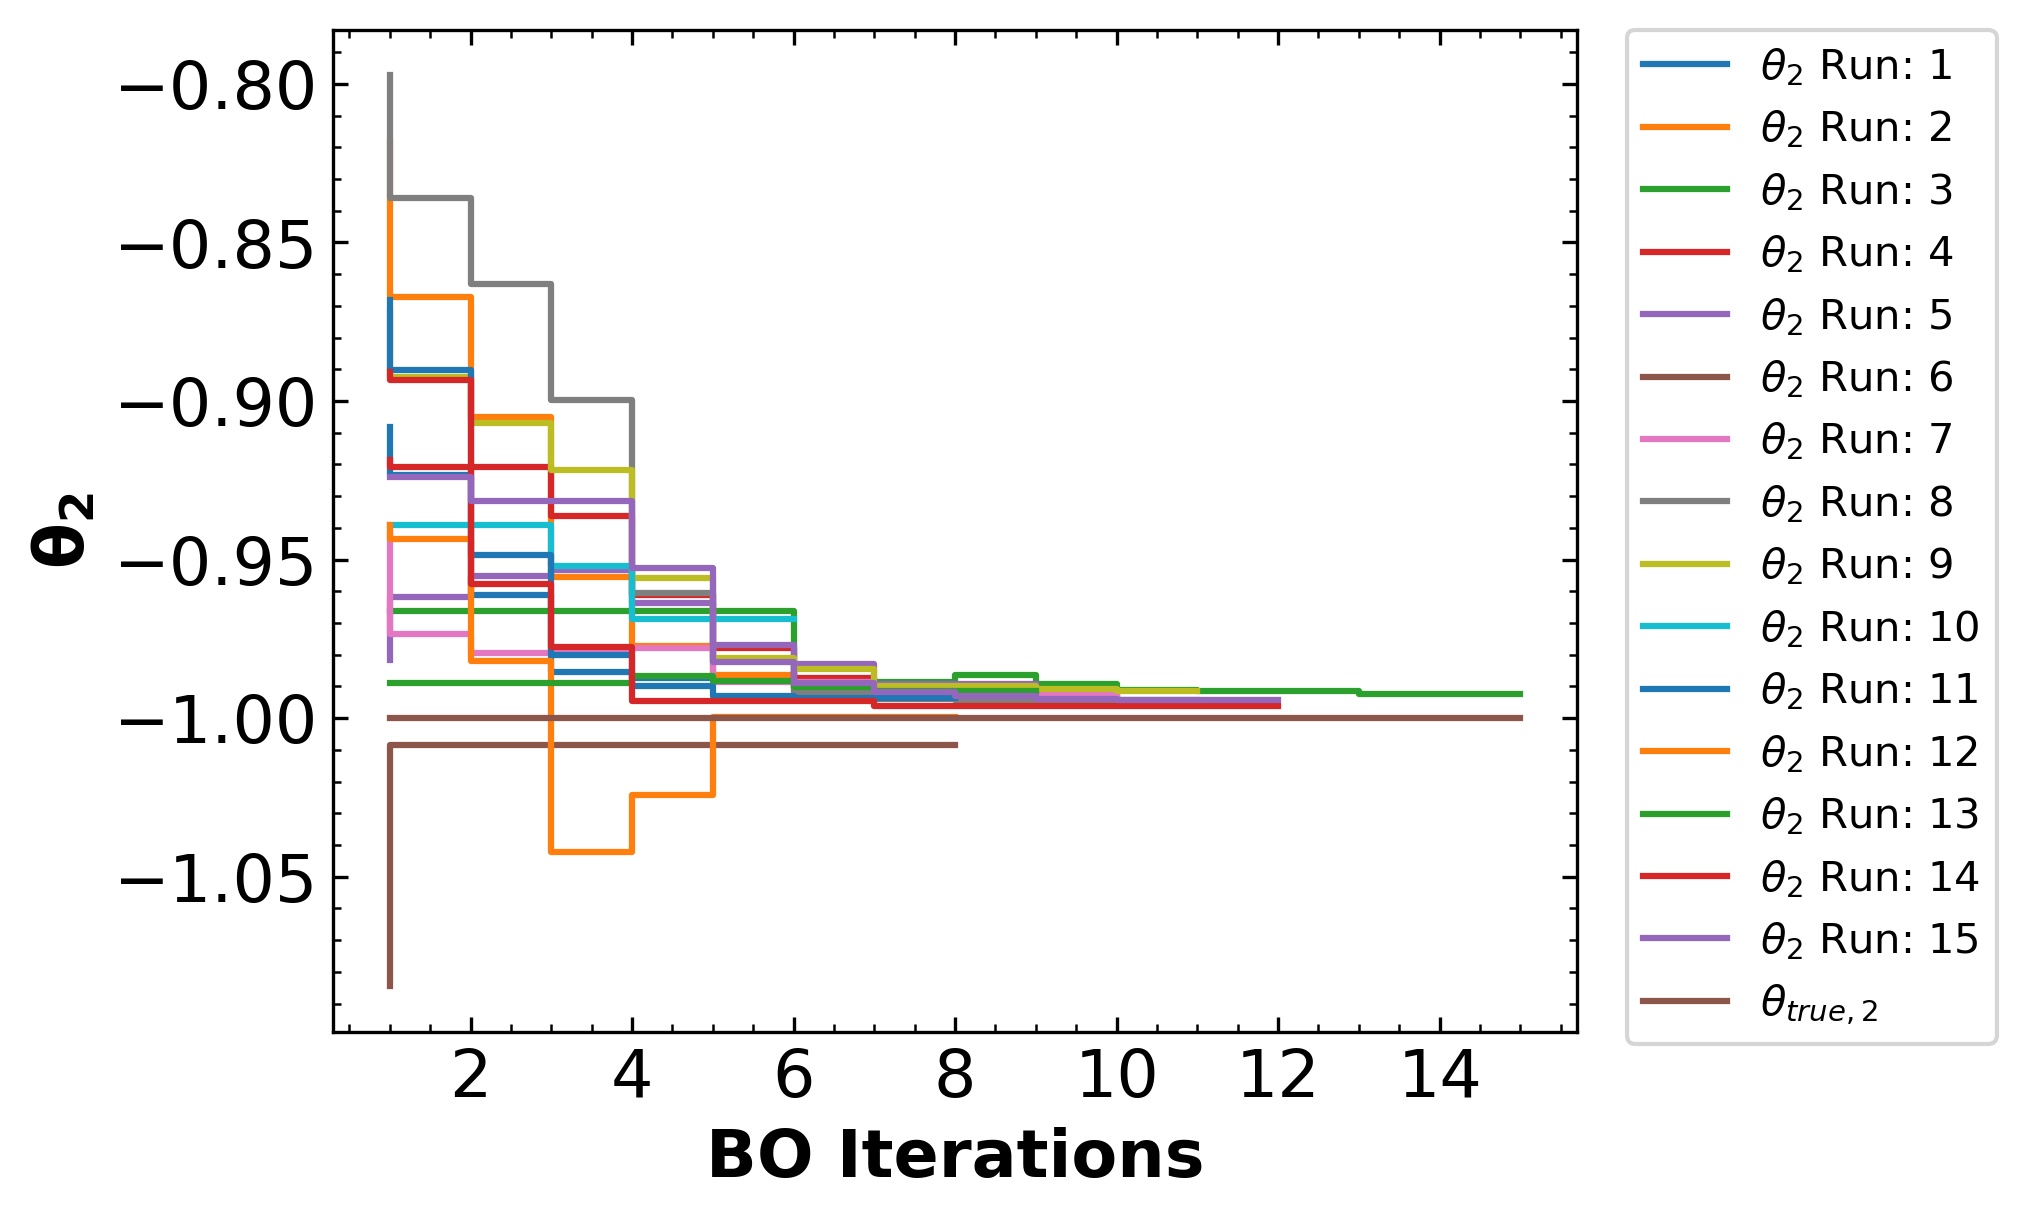

In [10]:
#WORKS
# save_figure = True
fxn = "plot_Theta_min"
csv_end_1 = "/Theta_Conv_min1.csv" #For Thetas #Need to ensure this saves correctly
csv_end_2 = "/Theta_Conv_min2.csv" #For Thetas

path_1 = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, bo_iter= None, 
          title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                 sep_fact = sep_fact, is_figure = is_figure, csv_end = csv_end_1)
path_2 = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, bo_iter= None, 
          title_save = None, run = None, tot_iter=tot_iter, tot_runs=tot_runs, DateTime = DateTime, 
                 sep_fact = sep_fact, is_figure = is_figure, csv_end = csv_end_2)
# print(path_1)

Theta_True = np.array([1,-1])
Theta_array_1 = csv_to_array(path_1)
Theta_array_2 = csv_to_array(path_2)
Theta_array = np.array([Theta_array_1,Theta_array_2])
# print(Theta_array)
plot_Theta_min(Theta_array.T, Theta_True, t, bo_iters, obj, ep, emulator, sparse_grid, set_lengthscale, save_figure = save_figure, 
           tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, nbins = 10)

(20, 20)


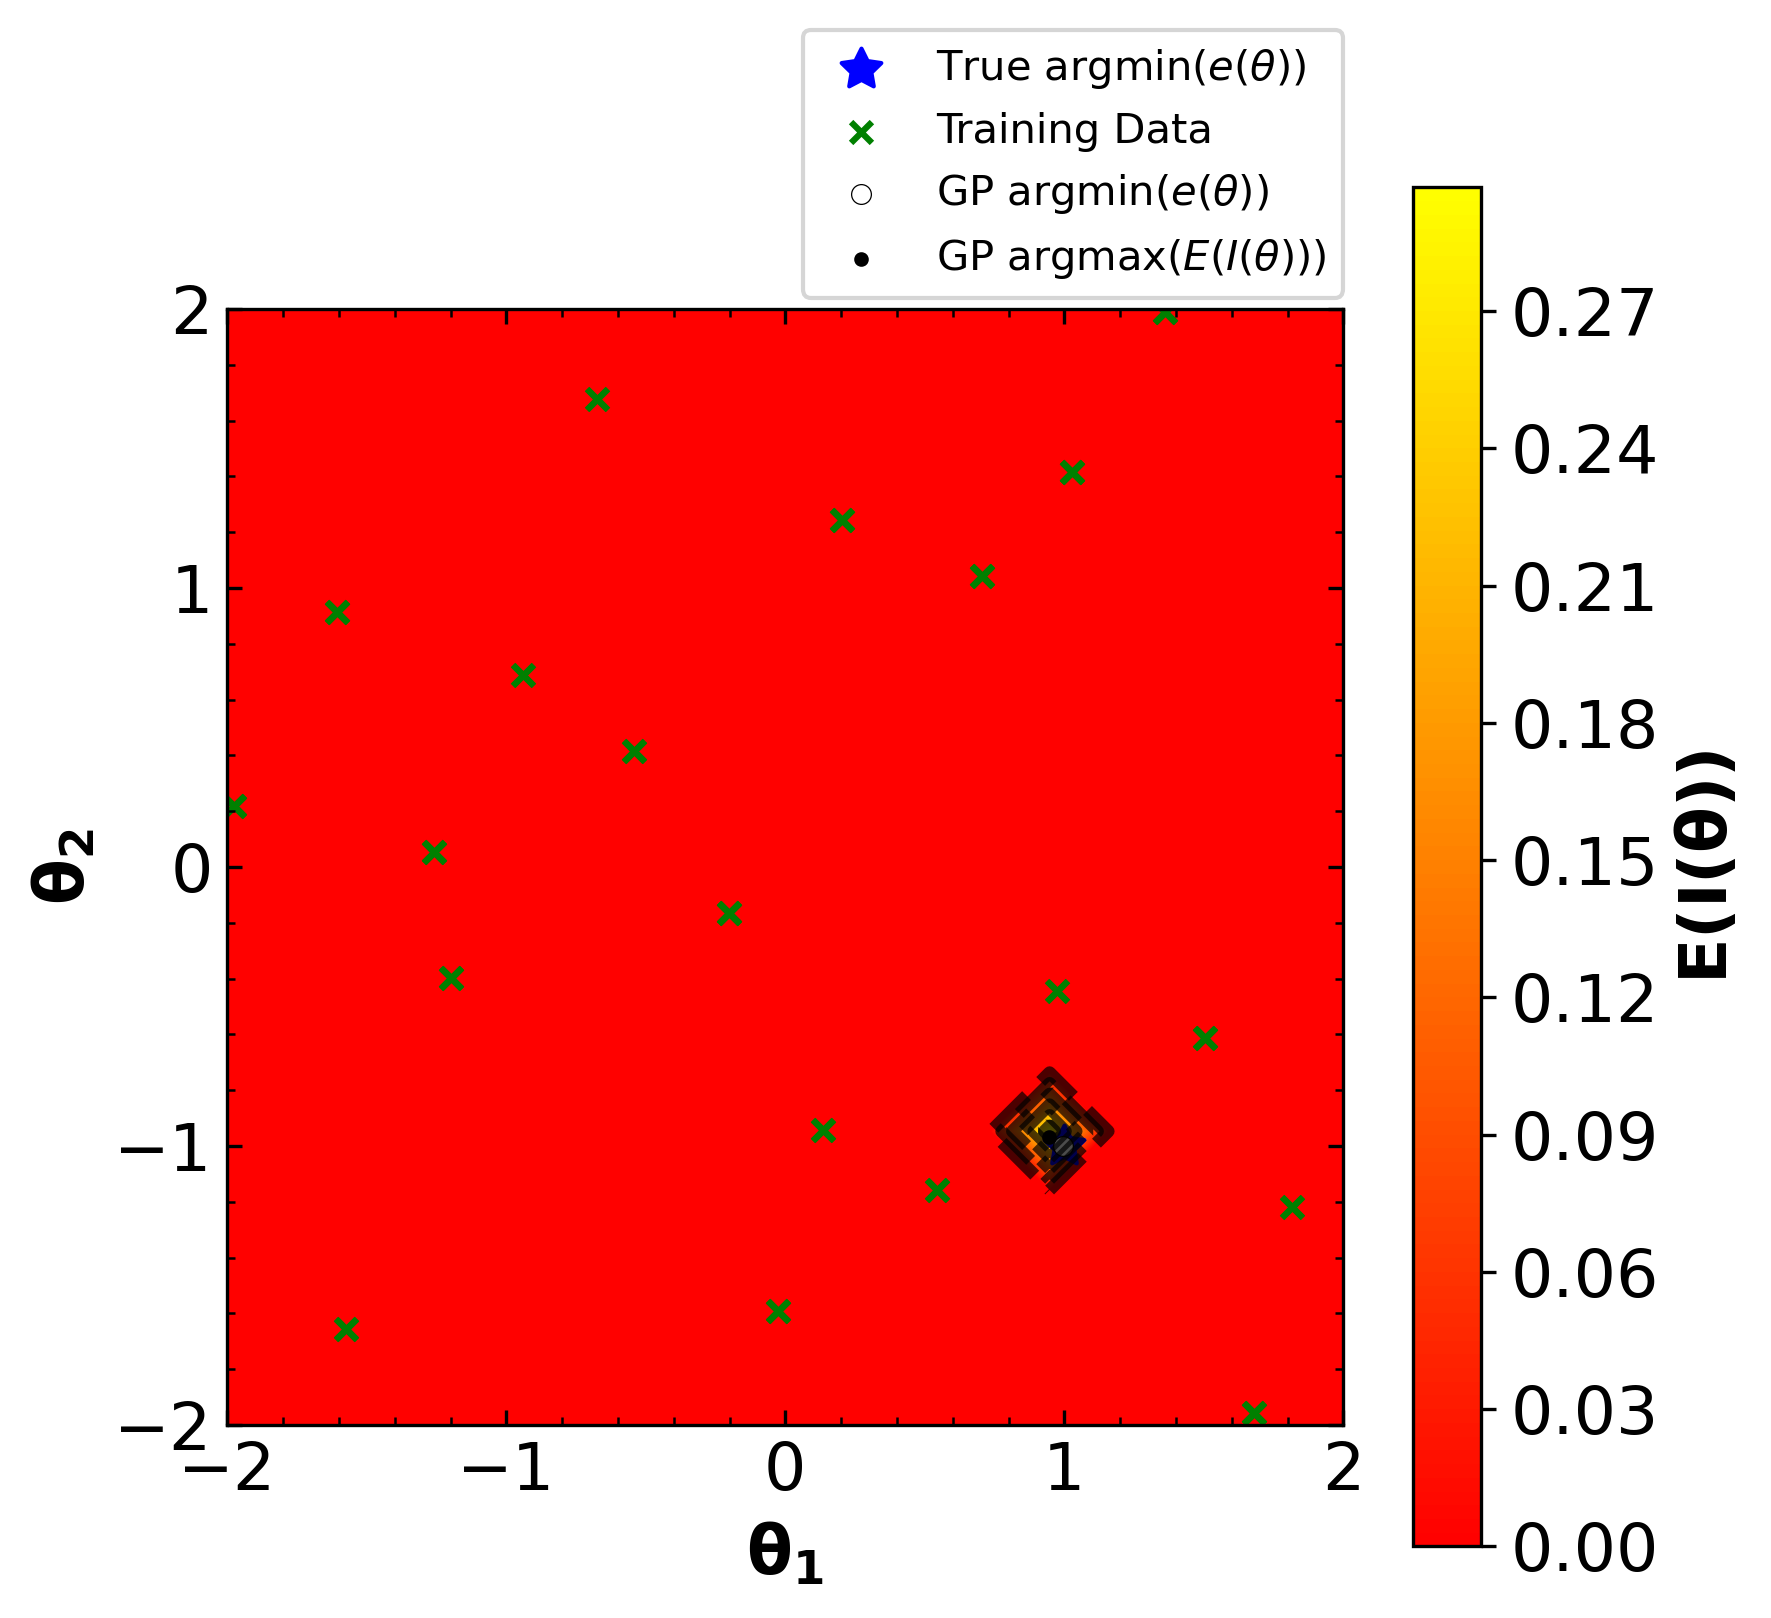

In [8]:
levels = 18

save_figure = False
# save_figure = True
# titles = ['E(I(\\theta))','log(e(\\theta))','\sigma^2','\sigma','Best_Error','z','EI_term_1','EI_term_2','CDF','PDF']  
# titles_save = ["EI","ln(SSE)","Var","StDev","Best_Error","z","ei_term_1","ei_term_2","CDF","PDF"] 

fxn = "value_plotter"

title_save = "EI"
title = 'E(I(\\theta))'

# title_save = "ln(SSE)"
# title = 'log(e(\\theta))'

path_title = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, Bo_iter, title_save, run, tot_iter=tot_iter, 
          tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, csv_end = "/" + title_save + ".csv")
path_best = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, Bo_iter, title_save, run, tot_iter=tot_iter, 
          tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, csv_end = "/" + "GP_Best_EI_Pred.csv")
path_opt = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, Bo_iter, title_save, run, tot_iter=tot_iter, 
          tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, csv_end = "/" + "GP_Min_SSE_Pred.csv")

fxn = "plot_org_train"
path_train = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, bo_iter=None, title_save = None, run = run, 
                       tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, 
                       csv_end = "/" + "train_theta.csv")
path_test = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, bo_iter=None, title_save = None, run = run, 
                       tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, 
                       csv_end = "/" + "test_theta.csv")
# print(path_ei)
train_p = csv_to_array(path_train)
p_GP_best = csv_to_array(path_best)
p_GP_opt = csv_to_array(path_opt)
z = csv_to_array(path_title)
print(z.shape)
value_plotter(theta_mesh, z, Theta_True, p_GP_opt, p_GP_best, train_p, title,title_save, obj,ep, emulator, sparse_grid, 
              set_lengthscale, save_figure, Bo_iter, run = run, tot_iter = tot_iter, tot_runs = tot_runs, 
              DateTime=DateTime, t = t, sep_fact = sep_fact, levels = levels)

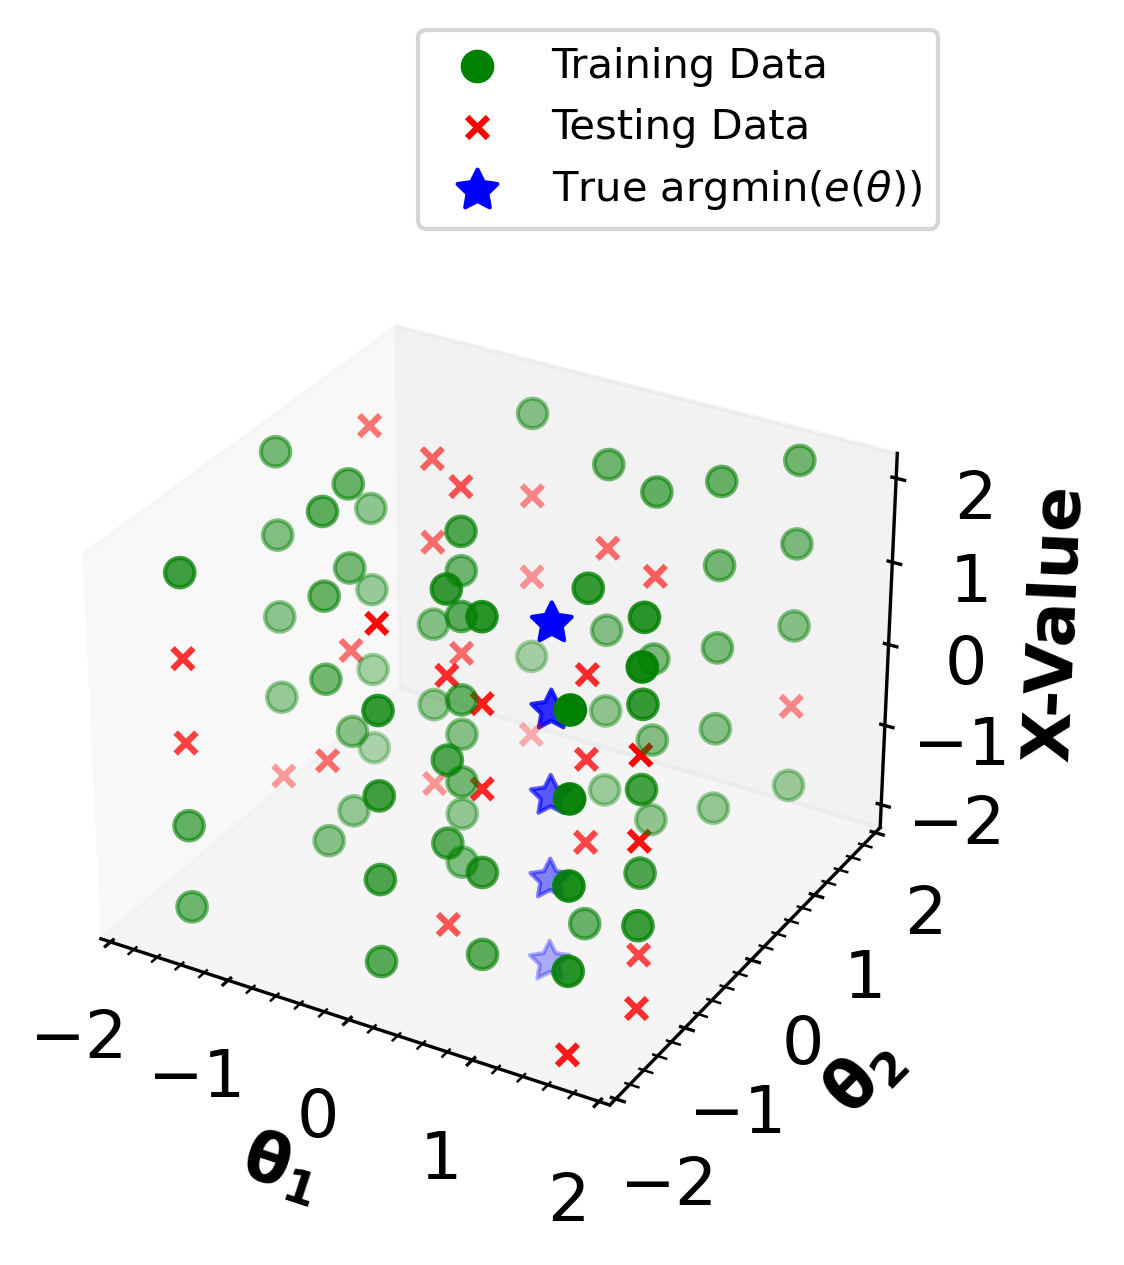

In [9]:
fxn = "plot_org_train"

path_train = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, bo_iter=None, title_save = None, run = run, 
                       tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, 
                       csv_end = "/" + "train_theta.csv")
path_test = path_name(emulator, ep, sparse_grid, fxn, set_lengthscale, t, obj, bo_iter=None, title_save = None, run = run, 
                       tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, sep_fact = sep_fact, is_figure = False, 
                       csv_end = "/" + "test_theta.csv")

train_p = csv_to_array(path_train)
test_p = csv_to_array(path_test)
plot_org_train(theta_mesh,train_p, test_p, Theta_True, emulator, sparse_grid, obj, ep, set_lengthscale, run, save_figure, 
               tot_iter=tot_iter, tot_runs=tot_runs, DateTime=DateTime, verbose = True, sep_fact = sep_fact)